In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import torch
import transformers
import baukit
from tqdm.auto import tqdm
import json
import os
from src import functional
import numpy as np
import logging
from src import models
from datasets import load_dataset

from src.utils import logging_utils, env_utils
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

torch.__version__, transformers.__version__, torch.version.cuda

/home/local_arnab/miniconda3/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.3.1', '4.43.3', '12.1')

In [70]:
# eval_dataset_name = "mickume/harry_potter_tiny"
eval_dataset_name = "jahjinx/IMDb_movie_reviews"
eval_data = load_dataset(eval_dataset_name)

2024-08-21 23:20:45 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/jahjinx/IMDb_movie_reviews HTTP/11" 200 1692
2024-08-21 23:20:45 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): s3.amazonaws.com:443
2024-08-21 23:20:45 urllib3.connectionpool DEBUG    https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/jahjinx/IMDb_movie_reviews/jahjinx/IMDb_movie_reviews.py HTTP/11" 404 0
2024-08-21 23:20:46 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/jahjinx/IMDb_movie_reviews HTTP/11" 200 1692
2024-08-21 23:20:46 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2024-08-21 23:20:46 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/jahjinx/IMDb_movie_reviews/resolve/ef30f6a046230c843d79822b928267efd9453d5b/README.md HTTP/11" 200 0
2024-08-21 23:20:46 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:

In [72]:
models = [
    "EleutherAI/pythia-160m",
    "EleutherAI/pythia-410m",
]
sae_datasets = [
    "wikimedia/wikipedia", "roneneldan/TinyStories"
]

cache_path_root = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "sae_mixtures", eval_dataset_name.split("/")[-1])
os.makedirs(cache_path_root, exist_ok=True)

In [ ]:
for model_name in models:
    for sae_data in sae_datasets:
        logger.info(f"model={model_name}, sae_data={sae_data}")
        cache_path = os.path.join(cache_path_root, model_name.split("/")[-1], sae_data.split("/")[-1])

        id_to_mixture = {}
        for sae_mixture_file in tqdm(os.listdir(cache_path)):
            data = np.load(os.path.join(cache_path, sae_mixture_file))
            # take the average of the reps as the feature #! Is this the best way to do it?
            sae_mixture = torch.Tensor(data["sae_mixture"]).squeeze().mean(dim=0)   
            id_to_mixture[int(sae_mixture_file.split(".")[0])] = sae_mixture
        
        all_states = []
        for doc_index in tqdm(range(len(eval_data["train"]))):
            all_states.append(id_to_mixture[doc_index])
        
        np.savez_compressed(
            os.path.join(cache_path_root, f"{model_name.split('/')[-1]}_{sae_data.split('/')[-1]}_states.npz"),
            all_states=all_states
        )

In [41]:
def load_cached_states(npz_path):
    npz = np.load(npz_path)
    states = torch.Tensor(npz["all_states"]).cuda()
    states = torch.nn.functional.normalize(states, p=2, dim=1) # normalize the rows

    return states

In [42]:
similarity_kernels = {}

for model_name in models:
    similarity_kernels[model_name] = {}
    for sae_data in sae_datasets:
        states = load_cached_states(os.path.join(cache_path_root, f"{model_name.split('/')[-1]}_{sae_data.split('/')[-1]}_states.npz"))
        similarity_kernels[model_name][sae_data] = states @ states.T

        logger.info(f"model={model_name}, sae_data={sae_data} | similarity_kernel.shape={similarity_kernels[model_name][sae_data].shape}")

2024-08-21 22:42:56 __main__ INFO     model=EleutherAI/pythia-160m, sae_data=wikimedia/wikipedia | similarity_kernel.shape=torch.Size([7481, 7481])
2024-08-21 22:42:56 __main__ INFO     model=EleutherAI/pythia-160m, sae_data=roneneldan/TinyStories | similarity_kernel.shape=torch.Size([7481, 7481])
2024-08-21 22:42:56 __main__ INFO     model=EleutherAI/pythia-410m, sae_data=wikimedia/wikipedia | similarity_kernel.shape=torch.Size([7481, 7481])
2024-08-21 22:42:57 __main__ INFO     model=EleutherAI/pythia-410m, sae_data=roneneldan/TinyStories | similarity_kernel.shape=torch.Size([7481, 7481])


2024-08-21 23:11:28 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f8bfde5f490>


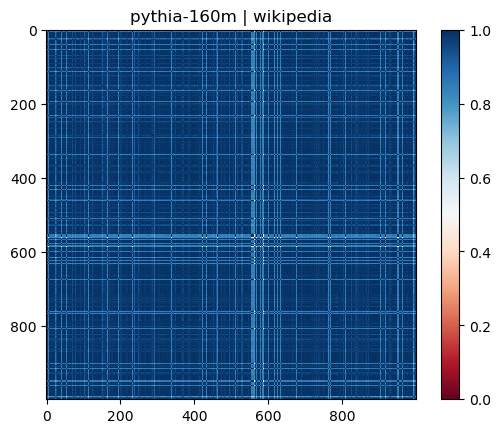

2024-08-21 23:11:28 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f8bfdd04490>


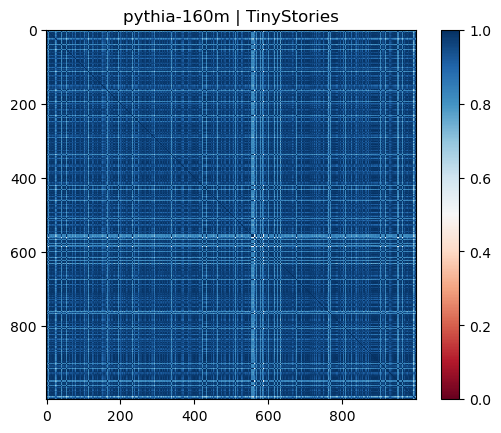

2024-08-21 23:11:29 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f8bfde73790>


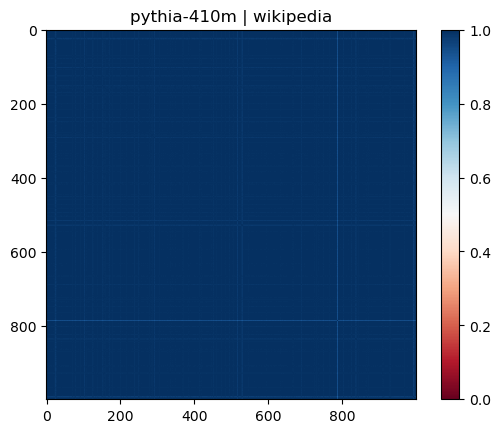

2024-08-21 23:11:29 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f8bfdca3510>


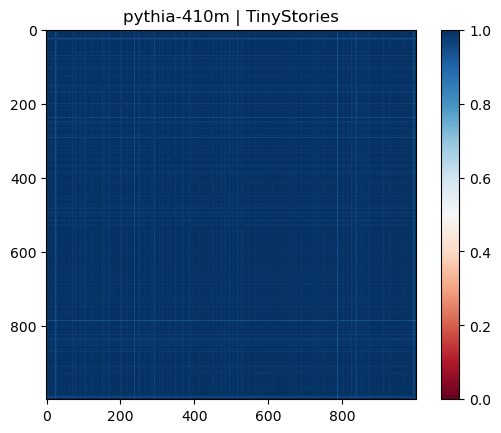

In [68]:
import matplotlib.pyplot as plt
from src.plotting import matrix_heatmap

for model_name in models:
    for sae_data in sae_datasets:
        matrix_heatmap(
            similarity_kernels[model_name][sae_data],
            title = f"{model_name.split('/')[-1]} | {sae_data.split('/')[-1]}",
            limit_dim = 1000,
        )
        idx += 1


In [62]:
from src.metrics import AlignmentMetrics

edges = []
edges.append(((models[0], sae_datasets[0]), (models[0], sae_datasets[1])))
edges.append(((models[0], sae_datasets[0]), (models[1], sae_datasets[0])))
edges.append(((models[1], sae_datasets[1]), (models[1], sae_datasets[0])))
edges.append(((models[1], sae_datasets[1]), (models[0], sae_datasets[1])))


for node1, node2 in edges:
    model_name_1, sae_data_1 = node1
    model_name_2, sae_data_2 = node2

    F1 = load_cached_states(os.path.join(cache_path_root, f"{model_name_1.split('/')[-1]}_{sae_data_1.split('/')[-1]}_states.npz"))
    F2 = load_cached_states(os.path.join(cache_path_root, f"{model_name_2.split('/')[-1]}_{sae_data_2.split('/')[-1]}_states.npz"))

    alignment_score = AlignmentMetrics.mutual_knn(F1, F2, topk = 500)
    logger.info(f'({model_name_1.split("/")[-1]},{sae_data_1.split("/")[-1]}) vs ({model_name_2.split("/")[-1]},{sae_data_2.split("/")[-1]}) | alignment_score={alignment_score}')

logger.info("-"*50)

cross = []
cross.append(((models[0], sae_datasets[0]), (models[1], sae_datasets[1])))
cross.append(((models[0], sae_datasets[1]), (models[1], sae_datasets[0])))

for node1, node2 in cross:
    model_name_1, sae_data_1 = node1
    model_name_2, sae_data_2 = node2

    F1 = load_cached_states(os.path.join(cache_path_root, f"{model_name_1.split('/')[-1]}_{sae_data_1.split('/')[-1]}_states.npz"))
    F2 = load_cached_states(os.path.join(cache_path_root, f"{model_name_2.split('/')[-1]}_{sae_data_2.split('/')[-1]}_states.npz"))

    alignment_score = AlignmentMetrics.mutual_knn(F1, F2, topk = 500)
    logger.info(f'({model_name_1.split("/")[-1]},{sae_data_1.split("/")[-1]}) vs ({model_name_2.split("/")[-1]},{sae_data_2.split("/")[-1]}) | alignment_score={alignment_score}')

2024-08-21 23:03:28 __main__ INFO     (pythia-160m,wikipedia) vs (pythia-160m,TinyStories) | alignment_score=0.5430777072906494
2024-08-21 23:03:28 __main__ INFO     (pythia-160m,wikipedia) vs (pythia-410m,wikipedia) | alignment_score=0.34716537594795227
2024-08-21 23:03:29 __main__ INFO     (pythia-410m,TinyStories) vs (pythia-410m,wikipedia) | alignment_score=0.28487128019332886
2024-08-21 23:03:29 __main__ INFO     (pythia-410m,TinyStories) vs (pythia-160m,TinyStories) | alignment_score=0.3821537494659424
2024-08-21 23:03:29 __main__ INFO     --------------------------------------------------
2024-08-21 23:03:29 __main__ INFO     (pythia-160m,wikipedia) vs (pythia-410m,TinyStories) | alignment_score=0.2627352178096771
2024-08-21 23:03:30 __main__ INFO     (pythia-160m,TinyStories) vs (pythia-410m,wikipedia) | alignment_score=0.27124878764152527
